# Lab 3: Introduction to Quantum Machine Learning

**Welcome to Lab 3!** In this lab, we will formally bridge the worlds of quantum computing and classical machine learning. You will see how a parameterized quantum circuit can *encode* a classical data vector into a high-dimensional Hilbert space.

The geometry of this quantum state space induces a "kernel" — a measure of similarity. We will show how to compute this kernel and feed it directly into a classical Support Vector Machine (SVM), creating a hybrid quantum-classical algorithm.

---

## Learning Objectives

* Understand the **kernel trick** in classical ML from a feature-mapping perspective.
* Define a **quantum feature map** $U_{\Phi}(x)$ as a parameterized quantum circuit.
* Derive and build the **overlap (test) circuit** used to compute a single kernel entry, $K(x_i, x_j)$.
* Formally connect the circuit’s measurement probability $P_0$ to the kernel value: $K(x_i, x_j) = |\langle\psi(x_i)|\psi(x_j)\rangle|^2 = P_0$.
* See the full workflow of feeding a quantum-computed **precomputed kernel** to `scikit-learn`.

---

## Recap from Lab 1 & 2: States, Oracles, and Composition

Let's formally connect what you've already mastered to what we'll do today.

* In **Lab 1 (Basics)**, you learned that a quantum state $|\psi\rangle$ is a vector in a complex Hilbert space $\mathcal{H}$. You used unitary operators $U$ (gates like $H, CNOT, R_y(\theta)$) to manipulate these vectors. You created complex states involving **superposition** ($H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$) and **entanglement** (Bell states), and used the `Sampler` to extract classical probabilities $P(i) = |\langle i|\psi\rangle|^2$.

* In **Lab 2 (Grover)**, you built a full algorithm by **composing** circuits. The key was the **Oracle** $U_f$, a circuit that *encoded* information (the solution $w$) into the state by applying a phase shift: $U_f|x\rangle = (-1)^{f(x)}|x\rangle$. You then composed $U_f$ with a **Diffuser** $U_s = 2|s\rangle\langle s| - I$ to perform amplitude amplification, geometrically rotating the state vector towards the solution.

### The Bridge to Quantum Machine Learning

Today, we will use these exact concepts in a new way.
1.  Instead of an **Oracle** $U_f$ that encodes a *single marked item* $w$, we will build a **Quantum Feature Map** $U_{\Phi}(x)$ that encodes a *classical data vector* $x$.
2.  This $U_{\Phi}(x)$ is a **parameterized quantum circuit**. The features of your data vector, $x = [x_1, x_2, ...]$, will be fed directly into the rotation angles of your gates (e.g., $R_y(x_1)$, $R_z(x_2)$).
3.  This circuit maps your classical data to a quantum state: $|\psi(x)\rangle = U_{\Phi}(x)|0\rangle^{\otimes n}$.
4.  Instead of amplifying one state, our goal is to measure the "similarity" between two such states, $|\psi(x_i)\rangle$ and $|\psi(x_j)\rangle$. This similarity, the kernel $K(x_i, x_j)$, will be computed by composing circuits, just as you did in Grover's algorithm.

In [13]:
# ======================================================
# Step 0 — Imports and tiny demo dataset (Qiskit ≥ 2.0)
# ======================================================
import numpy as np
import matplotlib.pyplot as plt

# (Optional) for table demos if you expand this later
import pandas as pd  # not strictly required below

# Qiskit core
from qiskit.circuit.library import z_feature_map, zz_feature_map, unitary_overlap
from qiskit.visualization import plot_distribution

# Transpiler presets (levelled optimization)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Sim and Runtime primitives (v2)
from qiskit.primitives import StatevectorSampler  # local simulator primitive
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler

## Part 1: The Theory (Classical ML)

### The Problem: Data We Can't Separate

In machine learning, a common goal is **classification**. Below you see two scenarios side-by-side:

- **Linearly Separable (left):** A single straight line (the dashed hyperplane) can separate the two classes (circles vs. pluses). Classical linear classifiers (e.g., a linear SVM) can find such a separating hyperplane.

- **Non-Linearly Separable (right):** The classes form clusters that cannot be split by any single straight line (triangles, squares, and circles overlap in complex ways). Problems like this motivate **feature maps** and the **kernel trick**, which implicitly lift data to a higher-dimensional space where linear separation may become possible.

---


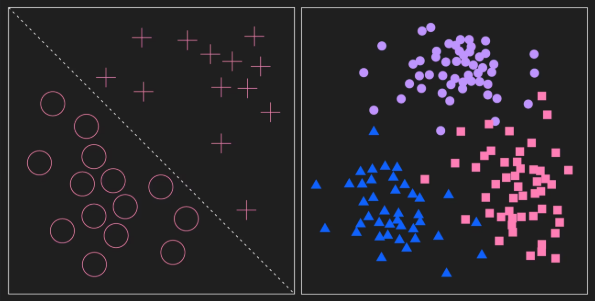

### 💡 The Solution: The "Magic" Mapping (The Feature Map $\Phi$)

The **kernel trick** offers a simple intuition: **if your data is hard to separate in its current space, lift it to a higher-dimensional one** where a linear separator might exist.



Let’s make this concrete with concentric circles.

1.  **Original data (2D).** A point is $x=(x_1,x_2)\in\mathbb{R}^2$.
    For example:
    * Red: $x_i=(1,0)$
    * Blue: $x_j=(2,0)$

2.  **The “magic” feature map.** Define a lift to 3D:
    $$\Phi(x) \;=\; \Phi\big((x_1,x_2)\big) \;=\; \big(x_1,\; x_2,\; x_1^2 + x_2^2\big)$$
    The new 3D coordinates live in the **feature space**.

3.  **What the lift does (examples).**
    * Red: $x_i=(1,0)\;\Rightarrow\;\Phi(x_i)=(1,0,1^2+0^2)=(1,0,1)$
    * Blue: $x_j=(2,0)\;\Rightarrow\;\Phi(x_j)=(2,0,2^2+0^2)=(2,0,4)$
    * Red: $x_k=(0,0.8)\;\Rightarrow\;\Phi(x_k)=(0,0.8,0^2+0.8^2)=(0,0.8,0.64)$
    * Blue: $x_\ell=(0,2.5)\;\Rightarrow\;\Phi(x_\ell)=(0,2.5,0^2+2.5^2)=(0,2.5,6.25)$

    **Pattern:** Inner (red) circle points have $z\approx 1$; outer (blue) ring points have $z\in[4,9]$.
    In this 3D space the classes become **linearly separable**: a single plane like $z=2$ separates them cleanly.

---

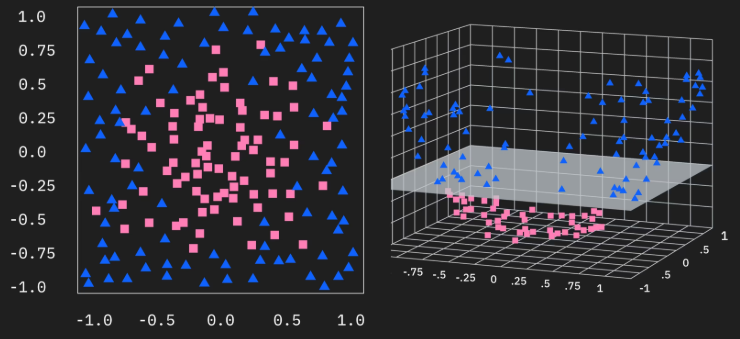

### The "Trick": Why We Use Kernels

That seems great, but there's a huge problem.
* **The "Curse of Dimensionality":** Our $\Phi$ function was simple. Real-world feature maps, like the popular **Radial Basis Function (RBF)**, implicitly map your data into an **infinite-dimensional** space.
* **The Cost:** You cannot compute or store an infinite-dimensional vector $\Phi(x)$ for every data point. It's computationally impossible.

**This is the "trick":** The SVM algorithm is special. It *never* needs to know the actual mapped vectors $\Phi(x_i)$. It *only* needs to know the **inner product** (or "dot product") between them.

The **inner product**, written $\langle v, w \rangle$, is just a single number that measures the "similarity" or "projection" of one vector onto another.
For $v = (v_1, v_2)$ and $w = (w_1, w_2)$, $\langle v, w \rangle = v_1w_1 + v_2w_2$.

So, the SVM needs:
$$K(x_i, x_j) = \langle \Phi(x_i), \Phi(x_j) \rangle$$

The **kernel** ($K$) is a magical "shortcut" function. It lets us calculate the result of this very expensive, high-dimensional inner product *while only doing calculations in our original, low-dimensional space.*

**Example (Polynomial Kernel):**
* **The Hard Way (explicit mapping):**
    1.  Let's use 1D data $x_i$ and a 3D feature map $\Phi(x) = (x^2, \sqrt{2}x, 1)$.
    2.  $\Phi(x_i) = (x_i^2, \sqrt{2}x_i, 1)$
    3.  $\Phi(x_j) = (x_j^2, \sqrt{2}x_j, 1)$
    4.  Compute the inner product:
        $\langle \Phi(x_i), \Phi(x_j) \rangle = (x_i^2 \cdot x_j^2) + (\sqrt{2}x_i \cdot \sqrt{2}x_j) + (1 \cdot 1) = x_i^2 x_j^2 + 2x_i x_j + 1$
    This was a lot of work.

* **The Easy Way (Kernel Trick):**
    1.  Define the kernel $K(x_i, x_j) = (x_i x_j + 1)^2$.
    2.  Let's expand it: $K(x_i, x_j) = (x_i x_j)^2 + 2(x_i x_j) + 1^2 = x_i^2 x_j^2 + 2x_i x_j + 1$.

**They are the exact same thing!** The kernel $K(x_i, x_j) = (x_i x_j + 1)^2$ gives us the result of a 3D dot product, but we only had to plug our original 1D numbers ($x_i, x_j$) into a simple formula.

This is the punchline for this lab:
> **A quantum circuit will be our `Kernel`. We will build a circuit that directly calculates the "similarity" $K(x_i, x_j)$ without ever needing to know what the terrifyingly large $\Phi(x)$ vector actually is.**

---

## Part 2: The Quantum Kernel (From Data to States)

### The Big Idea: A Hilbert Space is a Feature Space

In Part 1, we saw the "kernel trick" relies on a "magic" feature map $\Phi(x)$ to move data to a higher-dimensional space.

**The Quantum Idea:** What if our new "feature space" is the state space of a quantum computer?

This space is called a **Hilbert space**, and it's *enormous*.
* The state of 1 qubit is a 2D complex vector.
* The state of 2 qubits is a 4D complex vector.
* The state of $N$ qubits is a **$2^N$-dimensional** complex vector.

For a computer science student, this is the key:
* 10 qubits $\rightarrow 2^{10} = 1,024$ dimensions.
* 50 qubits $\rightarrow 2^{50} \approx 10^{15}$ dimensions.
* 300 qubits $\rightarrow$ More dimensions than all the atoms in the known universe.

This gives us access to a *colossal* feature space that classical computers cannot even store, let alone compute with. Our new goal is to map our classical data $x$ to a quantum state vector $|\psi(x)\rangle$ in this space.

---

### How to Encode Data: The Quantum Feature Map $U_{\Phi}(x)$

We need a way to "upload" our classical data $x = (x_1, x_2, ...)$ into the quantum computer. We do this with a **parameterized quantum circuit**, $U_{\Phi}(x)$, also called a **Quantum Feature Map**.

Think of a single qubit as a "globe," which we call the **Bloch Sphere**, as lab #1.

A qubit's state isn't just `0` or `1`; it can point *anywhere* on the surface of this sphere. We have **rotation gates** ($R_x, R_y, R_z$) that act as "knobs" to turn the state vector around the X, Y, or Z axis.

"Encoding data" simply means we **plug our data features into the angles of these rotation gates.**

**Example 1: 1D Data**
* **Data:** $x_i = 0.5$, $x_j = 1.8$
* **Encoding:** We could use the Y-axis. Our feature map is $U_{\Phi}(x) = R_y(x)$.
* $|\psi(x_i)\rangle = R_y(0.5) |0\rangle$
* $|\psi(x_j)\rangle = R_y(1.8) |0\rangle$

**Example 2: 2D Data**
* **Data:** $x_i = (x_{i1}, x_{i2})$
* **Encoding:** We can use multiple axes. Our map could be $U_{\Phi}(x) = R_y(x_1) R_z(x_2)$.
* $|\psi(x_i)\rangle = R_y(x_{i1}) R_z(x_{i2}) |0\rangle$

We can even "re-upload" data by repeating these gates to create very complex, non-linear maps (e.g., $R_y(x_1) \rightarrow R_z(x_2) \rightarrow CNOT \rightarrow R_y(x_1) \rightarrow R_z(x_2)$).

For $N$ qubits, we always start in the ground state $|0\rangle^{\otimes N}$ (all qubits are `0`) and apply our data-encoding circuit. This gives us our final, formal definition of the mapped state:

$$|\psi(x)\rangle = U_{\Phi}(x) |0\rangle^{\otimes N}$$

This state vector $|\psi(x)\rangle$ *is* our $\Phi(x)$ in the massive Hilbert feature space.

---

### 📐 How to Compute Similarity: The Quantum Kernel

In Part 1, the kernel was the inner product: $K(x_i, x_j) = \langle \Phi(x_i), \Phi(x_j) \rangle$.

Our quantum version is almost the same. The inner product between our two quantum states is $\langle \psi(x_i) | \psi(x_j) \rangle$. This is a complex number called a "probability amplitude."

However, as you learned in Lab 1, we can't measure amplitudes directly. We can only measure **probabilities**, which are the amplitudes *squared* (this is the Born rule).

Therefore, we define the **quantum kernel** as this physically measurable probability:

$$K(x_i, x_j) = \big|\langle \psi(x_i) \mid \psi(x_j) \rangle\big|^2$$

This gives us a real number between 0 and 1 that measures "similarity."
* **If $K(x_i, x_j) = 1$:** The states are identical.
* **If $K(x_i, x_j) = 0$:** The states are "orthogonal" (as different as possible).

### ⚙️ Deriving the "How-To": The Overlap Circuit

This is the most clever part. How do we build a circuit to measure $K(x_i, x_j)$?

Let's start with our kernel definition and substitute our circuit definitions back in.

1.  **The Kernel:**
    $$K(x_i, x_j) = \big|\langle \psi(x_i) \mid \psi(x_j) \rangle\big|^2$$

2.  **The States:**
    * $|\psi(x_j)\rangle = U_{\Phi}(x_j) |0\rangle^{\otimes N}$
    * $\langle \psi(x_i)| = \left( U_{\Phi}(x_i) |0\rangle^{\otimes N} \right)^\dagger = \langle 0|^{\otimes N} U_{\Phi}^\dagger(x_i)$

    *Wait, what is $U_{\Phi}^\dagger$?* The $\dagger$ (dagger) symbol means **conjugate transpose**. For a quantum circuit, it is the **inverse of the circuit**. It literally "runs the circuit backwards," undoing everything $U_{\Phi}$ did.

3.  **Substitute the States:**
    $$K(x_i, x_j) = \left|\left( \langle 0|^{\otimes N} U_{\Phi}^\dagger(x_i) \right) \left( U_{\Phi}(x_j) |0\rangle^{\otimes N} \right)\right|^2$$

4.  **Simplify:** We can group the operators in the middle.
    $$K(x_i, x_j) = \left|\langle 0|^{\otimes N} \left( U_{\Phi}^\dagger(x_i) U_{\Phi}(x_j) \right) |0\rangle^{\otimes N}\right|^2$$

**This final formula is a literal set of instructions, read from right-to-left:**

1.  Start with the state vector $|0\rangle^{\otimes N}$ (all qubits are `0`).
2.  Apply the circuit $U_{\Phi}(x_j)$ (this encodes $x_j$).
3.  To the result, apply the circuit $U_{\Phi}^\dagger(x_i)$ (this is the *inverse* of the circuit for $x_i$).
4.  You are now left with a final state, $|\psi_{\text{final}}\rangle = U_{\Phi}^\dagger(x_i) U_{\Phi}(x_j) |0\rangle^{\otimes N}$.
5.  The $\left|\langle 0|^{\otimes N} ... \right|^2$ part asks: "After running this whole combined circuit, what is the **probability of measuring all qubits back in the all-zeros state, $|00...0\rangle$?**"

**That probability, $P_0$, *is* our kernel value.**

This combined circuit, $U_{\Phi}^\dagger(x_i) U_{\Phi}(x_j)$, is called the **overlap** or **test circuit**. It's a machine built to estimate one single number, $K(x_i, x_j)$.

---

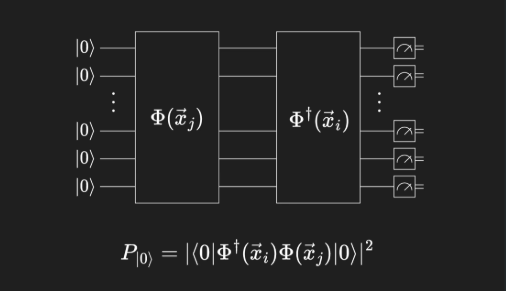

In [15]:
# -------------------------
# Two mock data points 
# -------------------------
small_data = [
    [-0.194,  0.114, -0.006,  0.301, -0.359, -0.088, -0.156,  0.342, -0.016,  0.143,  1],
    [-0.100,  0.002,  0.244,  0.127, -0.064, -0.086,  0.072,  0.043, -0.053,  0.020, -1],
]

# Data points with labels removed (feature-only vectors)
train_data = [small_data[0][:-1], small_data[1][:-1]]
np.set_printoptions(precision=3, suppress=True)

print("Feature dimension =", len(train_data[0]))

Feature dimension = 10


## Part 4: Building the Overlap Circuit

We need $U_\Phi^\dagger(x_i)\,U_\Phi(x_j)$ applied to $|0\rangle^{\otimes N}$, then we measure in the computational basis.

Steps:
1. Bind parameters with $x_j$ to get $U_\Phi(x_j)$.
2. Bind parameters with $x_i$ to get $U_\Phi(x_i)$, then invert it to obtain $U_\Phi^\dagger(x_i)$.
3. Compose to form the overlap circuit.
4. Optionally add measurements (the `Sampler` can infer outcome probabilities).

---


Circuit depth (un-decomposed) = 9
Circuit depth (decomposed)   = 9


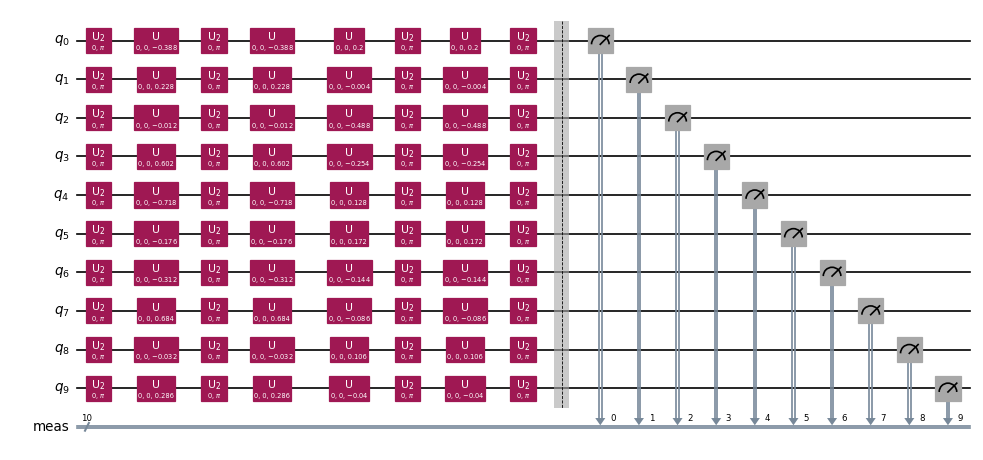

In [17]:
# ======================================================
# Step 1 — Build a feature map and the overlap circuit
# ======================================================

# You can switch between a shallow Z feature map and the (typically deeper) ZZ map.
fm = z_feature_map(feature_dimension=len(train_data[0]))
# Alternative (deeper): fm = zz_feature_map(feature_dimension=len(train_data[0]), entanglement='linear', reps=1)

# Bind two data points to obtain the unitaries U1 and U2
unitary1 = fm.assign_parameters(train_data[0])  # UΦ(x1)
unitary2 = fm.assign_parameters(train_data[1])  # UΦ(x2)

# Build the overlap circuit (applies U2 then U1† internally)
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()

print("Circuit depth (un-decomposed) =", overlap_circ.depth())
print("Circuit depth (decomposed)   =", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")


## Part 5: Execute and Extract the Kernel Value

We will use Qiskit’s `Sampler` to obtain a quasi-probability distribution over bitstrings for the overlap circuit. The kernel value is the probability of the all-zeros outcome.

- For two qubits, the all-zeros outcome corresponds to integer key `0` (bitstring `'00'`).

---


In [20]:
# ======================================================
# Step 3 — Execute using StatevectorSampler (local sim)
# ======================================================
from qiskit.primitives import StatevectorSampler

num_shots = 10_000
sv_sampler = StatevectorSampler()

# Run the simulator
sv_results = sv_sampler.run([sim_circ], shots=num_shots).result()

# .get_counts -> dict keyed by bitstrings ('000...'), .get_int_counts -> by integers (0,1,2,...)
counts_bit = sv_results[0].data.meas.get_counts()
counts_int = sv_results[0].data.meas.get_int_counts()

# Probability of the all-zeros outcome |00...0>, our kernel estimate P0
p0 = counts_int.get(0, 0) / num_shots
print("P(|0...0⟩) =", round(p0, 4))


P(|0...0⟩) = 0.6849


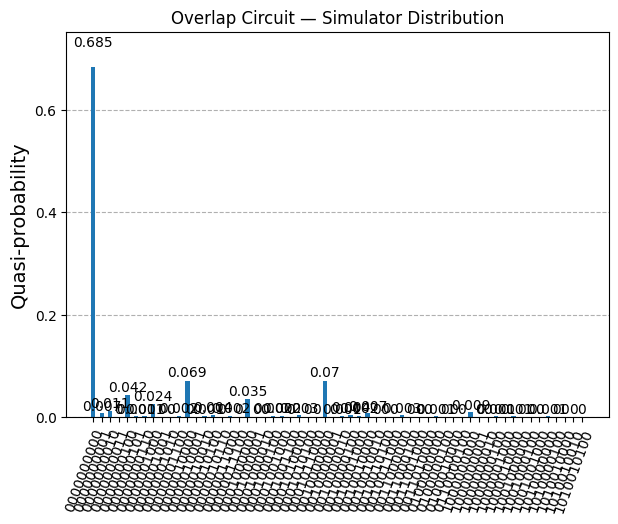

In [21]:
# =========================================
# Step 4 — Post-process and visualization
# =========================================
from qiskit.visualization import plot_distribution

plot_distribution(counts_bit, title="Overlap Circuit — Simulator Distribution")

Alternatively, one might define a visualization like the one below to look only at the top 10 most probable measurements. This could be important for troubleshooting or trying to glean more intuition for the data. But the measurement probability of the zero state is our kernel matrix element.

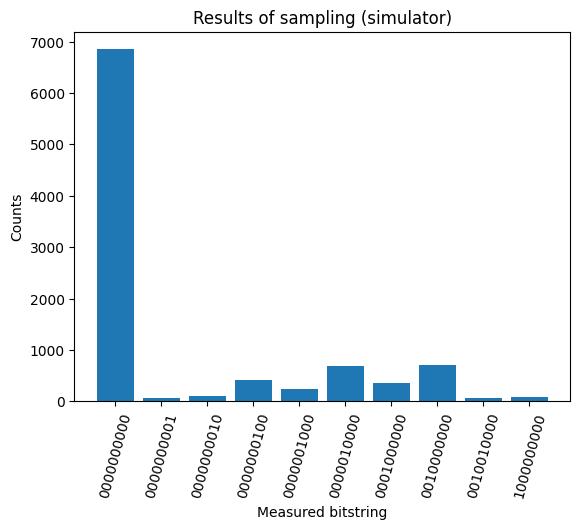

In [22]:
# (Optional) Helper to show top-10 outcomes + always include zero state
import matplotlib.pyplot as plt

def visualize_counts(probs_or_counts: dict, num_qubits: int):
    zero_val = probs_or_counts.get(0, 0.0)
    top_10 = dict(sorted(probs_or_counts.items(), key=lambda kv: kv[1], reverse=True)[:10])
    top_10.update({0: zero_val})  # ensure zero is shown
    by_key = dict(sorted(top_10.items(), key=lambda kv: kv[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(x)[2:].zfill(num_qubits) for x in xvals]

    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling (simulator)")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()

visualize_counts(counts_int, sim_circ.num_qubits)

> This plot shows a high probability for the all-zero state, $P_0$, meaning this one kernel entry $K(x_i, x_j)$ is large. This suggests two possibilities:
>
> 1.  The two data points are truly similar.
> 2.  Our feature map is not effective and is mapping all data to similar states.
>
> We cannot know from a single entry. The only way to be sure is to compute the **full kernel matrix** for the entire dataset and see if it can be used to effectively separate the classes.

Deeper map — decomposed depth: 58
P(|0...0⟩) with ZZ feature map = 0.0225


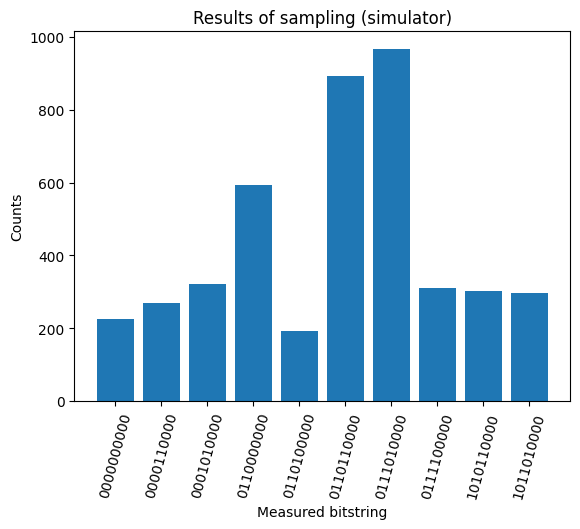

In [25]:
# ==========================================================
# (Optional) Try a deeper feature map and compare P(|0...0⟩)
# ==========================================================
from qiskit.circuit.library import zz_feature_map, unitary_overlap

# Build a deeper feature map (typically higher two-qubit depth)
fm_deeper = zz_feature_map(
    feature_dimension=len(train_data[0]),
    entanglement='linear',
    reps=1
)

# Bind two data points
U1 = fm_deeper.assign_parameters(train_data[0])
U2 = fm_deeper.assign_parameters(train_data[1])

# Build overlap circuit
overlap_deeper = unitary_overlap(U1, U2)

# Inspect depth *before* adding measurements
print("Deeper map — decomposed depth:", overlap_deeper.decompose().depth())

# Add measurements IN-PLACE (do NOT reassign the return)
overlap_deeper.measure_all()

# Run with the same StatevectorSampler (simulator)
res_deeper = sv_sampler.run([overlap_deeper], shots=num_shots).result()

# Extract counts / P0
counts_bit_deeper = res_deeper[0].data.meas.get_counts()
counts_int_deeper = res_deeper[0].data.meas.get_int_counts()
p0_deeper = counts_int_deeper.get(0, 0) / num_shots

print("P(|0...0⟩) with ZZ feature map =", round(p0_deeper, 4))

# Visualize TOP-10 outcomes using the helper defined earlier
visualize_counts(counts_int_deeper, overlap_deeper.num_qubits)

> It's important to consider **circuit depth**. We used `z_feature_map`, which is very shallow (depth 1). Deeper circuits accumulate more noise, which incorrectly reduces the $P_0$ (zero state) probability.
>
> For example, running the same data with a `zz_feature_map` (which is deeper) yields $P_0 \approx 0.0225$. The plot below shows how this noise distributes the probabilities.
>
> **General Advice:**
> * **Depth $\le 10$ (on 2 qubits):** Usually no problem.
> * **Depth 50-60:** State-of-the-art; requires advanced error mitigation.
>
> In the next section, we will extend this process from a single kernel entry to an entire dataset and show the full classical machine learning workflow.

## Self-Check Questions

1. **In a 10-qubit circuit, how many basis states are measurable?**  
   **Answer:** $2^{10}=1024$.

2. **Suppose an error rate of $10\%$ per qubit with no mitigation and the ideal kernel element is $1.0$.  
   What is the probability that all 10 qubits are measured in $|0\rangle$?**  
   **Answer:** $0.9^{10} \approx 0.35$.

3. **Why monitor circuit depth in quantum kernel estimation?**  
   **Answer:** Kernel values are extracted from measurement probabilities (e.g., $P_0$). Deep circuits accumulate noise (especially two-qubit errors), degrading $P_0$ and thus the kernel matrix, harming downstream SVM performance.

---


## Part 6: Building the **Full Kernel Matrix** and Training a Classical SVM

We now scale from **one** overlap value $K(x_i,x_j)=P_0$ to the **entire** kernel matrix $\mathbf{K}$ over a training set, plus a **test matrix** $\mathbf{K}_{\text{test}}$ between test and training points. Both are computed with the **overlap circuit**:
$$
K(x_i,x_j) \;=\; \Big|\big\langle 0^{\otimes N}\big|\,U_\Phi^\dagger(x_i)\,U_\Phi(x_j)\,\big|0^{\otimes N}\big\rangle\Big|^2
$$

We will:
1. Load a small dataset (as in IBM’s tutorial): 128 rows, 14 features, and a label $\pm 1$.
2. Split the first 90 for **training** and the next 30 for **testing**.
3. Build a **feature map** $U_\Phi(x)$ (custom, shallow).
4. Use the **StatevectorSampler** (local simulator) to estimate $P_0$ and fill $\mathbf{K}$ and $\mathbf{K}_{\text{test}}$.
5. Train a classical **SVM** with `kernel='precomputed'` on $\mathbf{K}$, and evaluate on $\mathbf{K}_{\text{test}}$.

---

In [29]:
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
 
df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
 
# Prepare training data
 
# Prepare training / testing splits
train_size = 90
test_size  = 30

X_train = df.values[:train_size, :-1]
y_train = df.values[:train_size, -1].astype(int)

X_test  = df.values[train_size:train_size + test_size, :-1]
y_test  = df.values[train_size:train_size + test_size, -1].astype(int)

X_train.shape, X_test.shape, y_train[:5], y_test[:5]

--2025-11-05 21:30:22--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49405 (48K) [text/plain]
Saving to: ‘dataset_graph7.csv.1’

dataset_graph7.csv. 100%[===================>]  48.25K  --.-KB/s    in 0.008s  

2025-11-05 21:30:22 (6.07 MB/s) - ‘dataset_graph7.csv.1’ saved [49405/49405]



((90, 14), (30, 14), array([ 1, -1,  1, -1,  1]), array([ 1, -1,  1, -1,  1]))

### Allocate the Kernel and Test Matrices

We’ll store:
- $\mathbf{K}\in\mathbb{R}^{n\times n}$ for training–training pairs.
- $\mathbf{K}_{\text{test}}\in\mathbb{R}^{m\times n}$ for test–training pairs.

We will exploit symmetry $K(x_i,x_j)=K(x_j,x_i)$ and set the diagonal to $1$ (ideal, noiseless case).

---

In [30]:
num_samples = X_train.shape[0]
K = np.full((num_samples, num_samples), np.nan)
K_test = np.full((X_test.shape[0], num_samples), np.nan)

K.shape, K_test.shape


((90, 90), (30, 90))

### Build a Custom, Shallow **Feature Map** $U_\Phi(x)$

- Use $N=\tfrac{\text{num\_features}}{2}$ qubits.
- Parameter vector $\mathbf{x}$ for the 14 features, and an extra **training angle** $\theta$ (set to $\pi/2$ when binding).
- A few entangling $CZ$s and single-qubit $R_z, R_x$ “data re-uploading” layers to keep **depth** small.

You can adjust the **entangler map** to study depth vs. performance.

---

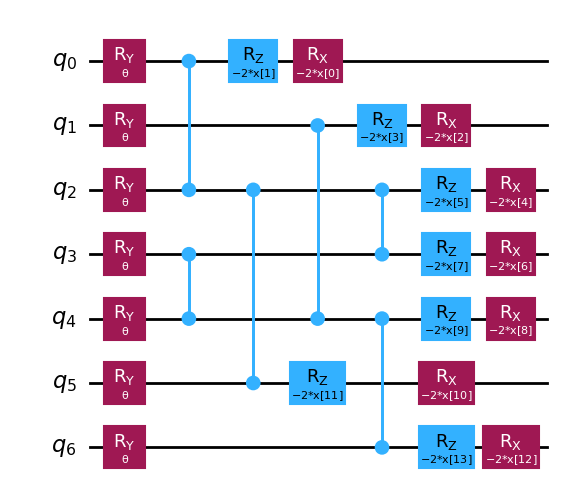

In [31]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

num_features = X_train.shape[1]
assert num_features % 2 == 0, "This feature map expects an even number of features."
num_qubits = num_features // 2

# Entangler pairs (edit if desired)
entangler_map = [(0, 2), (3, 4), (2, 5), (1, 4), (2, 3), (4, 6)][: max(0, num_qubits-1)]

# Build the parametric circuit
theta = Parameter("θ")
xvec  = ParameterVector("x", length=num_qubits * 2)

fm = QuantumCircuit(num_qubits)
# Small "global" rotation layer controlled by θ
fm.ry(theta, fm.qubits)
# Sparing entanglement
for a, b in entangler_map:
    if a < num_qubits and b < num_qubits:
        fm.cz(a, b)
# Simple data re-uploading per qubit
for i in range(num_qubits):
    fm.rz(-2 * xvec[2*i + 1], i)
    fm.rx(-2 * xvec[2*i],     i)

fm.draw("mpl")


### Build the Overlap Circuit and Fill the Matrices (Simulator)

For each pair $(x_i,x_j)$, we:
1. Bind parameters for $U_\Phi(x_i)$ and $U_\Phi(x_j)$ (we append $\theta=\pi/2$).
2. Build the **overlap** $U_\Phi^\dagger(x_i)\,U_\Phi(x_j)$.
3. Measure $P_0$ using `StatevectorSampler`, and insert into $\mathbf{K}$ (or $\mathbf{K}_{\text{test}}$).

---

In [32]:
from qiskit.circuit.library import unitary_overlap
from qiskit.primitives import StatevectorSampler

num_shots = 10_000
sampler = StatevectorSampler()

# ---- Fill training kernel matrix K (upper triangle + diagonal) ----
for i in range(num_samples):
    K[i, i] = 1.0  # ideal property (noiseless)
    for j in range(i + 1, num_samples):
        U_i = fm.assign_parameters(list(X_train[i]) + [np.pi / 2])
        U_j = fm.assign_parameters(list(X_train[j]) + [np.pi / 2])

        overlap_circ = unitary_overlap(U_i, U_j)
        overlap_circ.measure_all()

        res = sampler.run([overlap_circ], shots=num_shots).result()
        counts_int = res[0].data.meas.get_int_counts()
        p0 = counts_int.get(0, 0) / num_shots

        K[i, j] = p0
        K[j, i] = p0  # symmetry

print("Filled training kernel matrix K.")

# ---- Fill test matrix K_test (test vs train) ----
for i in range(X_test.shape[0]):
    for j in range(num_samples):
        U_t = fm.assign_parameters(list(X_test[i]) + [np.pi / 2])
        U_tr = fm.assign_parameters(list(X_train[j]) + [np.pi / 2])

        overlap_circ = unitary_overlap(U_t, U_tr)
        overlap_circ.measure_all()

        res = sampler.run([overlap_circ], shots=num_shots).result()
        counts_int = res[0].data.meas.get_int_counts()
        p0 = counts_int.get(0, 0) / num_shots

        K_test[i, j] = p0

print("Filled test matrix K_test.")


Filled training kernel matrix K.
Filled test matrix K_test.


### Train a Classical SVM on the Precomputed Quantum Kernel

We pass $\mathbf{K}$ to scikit-learn with `kernel='precomputed'`, and evaluate on $\mathbf{K}_{\text{test}}$.

---

In [33]:
from sklearn.svm import SVC

svc = SVC(kernel="precomputed")
svc.fit(K, y_train)

test_score = svc.score(K_test, y_test)
print(f"Precomputed quantum-kernel classification — test accuracy: {test_score:.3f}")


Precomputed quantum-kernel classification — test accuracy: 1.000


### (Optional) Visualize the Kernel Matrices

Below we plot $\mathbf{K}$ and $\mathbf{K}_{\text{test}}$ as heatmaps to build intuition.
Bright blocks indicate **high similarity** (large overlaps), darker regions indicate **low similarity**.

---

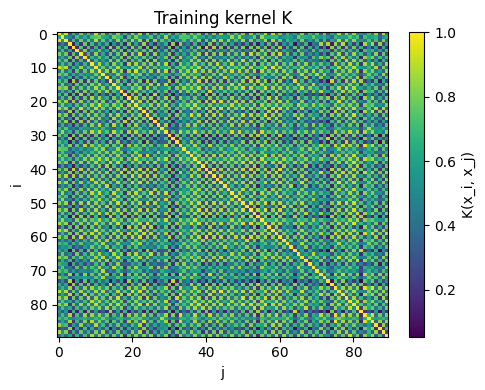

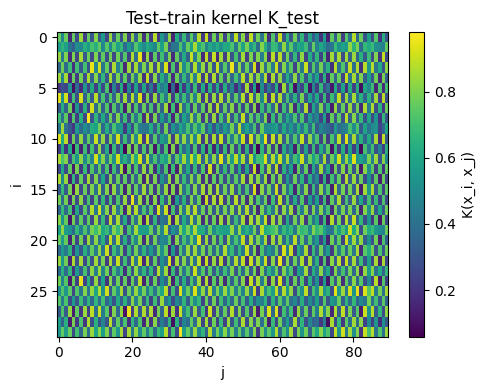

In [34]:
import matplotlib.pyplot as plt

def show_heatmap(M, title):
    plt.figure(figsize=(5,4))
    plt.imshow(M, cmap="viridis", interpolation="nearest", aspect="auto")
    plt.colorbar(label="K(x_i, x_j)")
    plt.title(title)
    plt.xlabel("j")
    plt.ylabel("i")
    plt.tight_layout()
    plt.show()

show_heatmap(K, "Training kernel K")
show_heatmap(K_test, "Test–train kernel K_test")


## Part 7: Conclusions, Notes, & Next Steps

This lab demonstrated the full workflow of a Quantum Kernel Estimator (QKE). We successfully trained a classical SVM with a kernel matrix computed entirely on a quantum (simulator).

---

### 📊 Key Takeaways & Practical Tips

* **Performance vs. Advantage:** We achieved high accuracy, but this **is not quantum advantage**. A classical kernel (like `rbf`) could likely solve this small problem just as well. The goal is to find problems where quantum kernels *significantly outperform* classical ones. Always run a classical baseline.

* **The Computational Cost:** Notice the number of circuits we had to build. For $n=90$ training points and $m=30$ test points:
    * **Training Matrix $\mathbf{K}$ ($90 \times 90$):** This matrix is symmetric ($K(x_i,x_j) = K(x_j,x_i)$). We only need to compute the upper triangle, which is $\frac{n(n+1)}{2} = \frac{90 \times 91}{2} = 4,095$ overlap circuits.
    * **Test Matrix $\mathbf{K}_{\text{test}}$ ($30 \times 90$):** This matrix has no symmetry, requiring all $m \times n = 30 \times 90 = 2,700$ overlap circuits.
    * **Total:** We executed **6,795** unique quantum circuits. This scaling ($O(n^2)$) is a major consideration for QML.

* **Depth is Critical:** As your feature map `reps` or `entanglement` increases, the circuit depth rises. On real QPUs, noise will quickly "wash out" the $P_0$ signal, destroying your kernel values. **Always prefer shallow maps** for real hardware or use error mitigation.

* **Diagonals Matter:** In our ideal, noiseless simulation, $K(x,x)=1$. On real hardware, $K(x,x)$ will be $< 1$ due to noise. Measuring the diagonal entries gives you a good estimate of the noise level (or "fidelity") of your feature map.

---

### 🚀 Your Turn: Questions to Explore

The field of QML is still wide open. Use this lab as a sandbox and try to answer the following questions:

* **Robustness:** How does the accuracy change if you use a different 90/30 split of the data?
* **Data Structure:** What kind of data structure might *actually* benefit from a quantum feature map? (Hint: think about problems related to quantum mechanics itself).
* **Scaling:** How is the accuracy affected by increasing or decreasing the amount of training data?
* **Hyperparameters:** How do the results vary if you use a different feature map (like `ZFeatureMap`, `ZZFeatureMap`) or change the `reps` and `entangler_map`?
* **Real Hardware:** Which of these trends (if any) do you expect to hold when you run on a real, noisy quantum computer?